In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import math
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,LeakyReLU,ZeroPadding2D
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
faceDetector = cv2.dnn.readNetFromCaffe(os.path.join('Program','Models','deploy.prototxt.txt'),os.path.join('Program','Models','res10_300x300_ssd_iter_140000.caffemodel'))
loaded_model_face = keras.models.load_model(os.path.join('Program','Models','faceModel629-self.h5'))

In [3]:
def extractFrames(path):
    video = cv2.VideoCapture(path)
    
    frameRate = video.get(5) #frame rate
    extractedFrames = []

    while(video.isOpened()):
        frameId = video.get(1) #current frame number
        ret, frame = video.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0): #every second save the first frame
            rgbImage = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            extractedFrames.append(rgbImage)
    video.release()

    return extractedFrames

In [4]:
def getCroppedFaceRegions(frames,faceDetector):
    cropped = []
    
    for frame in frames:
        # Detect faces
        h, w = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
        faceDetector.setInput(blob)
        faces = faceDetector.forward()

        try:
            for i in range(faces.shape[2]):
                confidence = faces[0, 0, i, 2]
                if confidence > 0.7:
                    box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
                    (x1, y1, x2, y2) = box.astype("int")
                    face_rgb = frame[y1:y2,x1:x2]
                    cropped.append(cv2.resize(face_rgb,(48,48)))

        except cv2.error as e:
            print('[Unknown error] Invalid face!')
        
    return cropped

In [5]:
def faceRecog(faces,model):
    result = []
    print('Angry       Happy      Neutral    Sad')
    for face in faces:
        img = face.astype('float32') / 255.0
        img = img.reshape(-1, 48, 48, 1)
        print(model.predict(img)[0])
        result.append(model.predict(img)[0])
    
    faceTotal = len(result)
    finalFaceResult = []
    
    #calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalFaceResult.append(sumEmotion/faceTotal)
    
    # Round up to 4 decimal places
    finalFaceResult = [np.round(num, 4) for num in finalFaceResult]
    print('---------------------------------------------')
    print('Final face results:',finalFaceResult)
    
    return finalFaceResult

In [6]:
def shows(images):
    n = len(images)
    fig = plt.subplots(nrows=1, ncols=n)
    
    for i in range(n):
        num = 100 + n*10 + (i+1)
        plt.subplot(num)
        plt.title("")
        plt.xticks([]), plt.yticks([])
        if images[i].ndim == 2:
            plt.imshow(images[i], cmap='gray') #if not specified, it will treat this image as heat map
        else:
            plt.imshow(images[i])
        
    plt.show()

In [7]:
def shows2(images):
    num = 5
    n = math.ceil(len(images)/num)
    plt.figure(0)
    counter = 0
    stop = False

    for i in range(n):
        for j in range(num):
            plt.subplot2grid((n,num), (i,j))
#             plt.rcParams["figure.figsize"] = (1,1)
            plt.title("")
            plt.xticks([]), plt.yticks([])
            if images[counter].ndim == 2:
                plt.imshow(images[counter], cmap='gray') #if not specified, it will treat this image as heat map
            else:
                plt.imshow(images[counter])
            if counter == len(images)-1:
                stop = True
                break
            else:
                counter += 1
        if stop:
            break
        
    plt.show()

In [8]:
def display(faceResult):
    # Recreating dataframe without datetime and separated by recognition type
    emotions = ['Angry','Happy','Neutral','Sad']
    dfFace = pd.DataFrame(columns=['Emotion','Emotion Recognition by Facial Expression'])
    c = 0

    for i,emo in enumerate(emotions):
        dfFace.loc[c] = [emo,faceResult[i]]
        c+=1

    # Setting of graphs
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set(font_scale = 1.5)
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Emotion Recognition")
    
    face = sns.barplot(x="Emotion",
                       y="Emotion Recognition by Facial Expression",
                       data=dfFace,
                       ax=axes[0])
    
    face.set_title("Emotion Recognition by Facial Expression")
    face.set_xlabel("Emotion")
    face.set_ylabel("Recognition Result")
    
    for p in face.patches:
        face.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

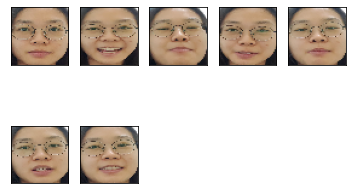

Angry       Happy      Neutral    Sad
[0.7430237  0.05855308 0.10146534 0.09695796]
[0.76324296 0.06632335 0.08468883 0.08574487]
[0.72850627 0.04576638 0.15512021 0.07060723]
[0.62307656 0.11802991 0.1646212  0.09427234]
[0.7164959  0.06466084 0.13022645 0.08861689]
[0.76356655 0.04983044 0.1078437  0.07875925]
[0.7784291  0.0416363  0.10169891 0.07823578]
---------------------------------------------
Final face results: [0.7309, 0.0635, 0.1208, 0.0847]


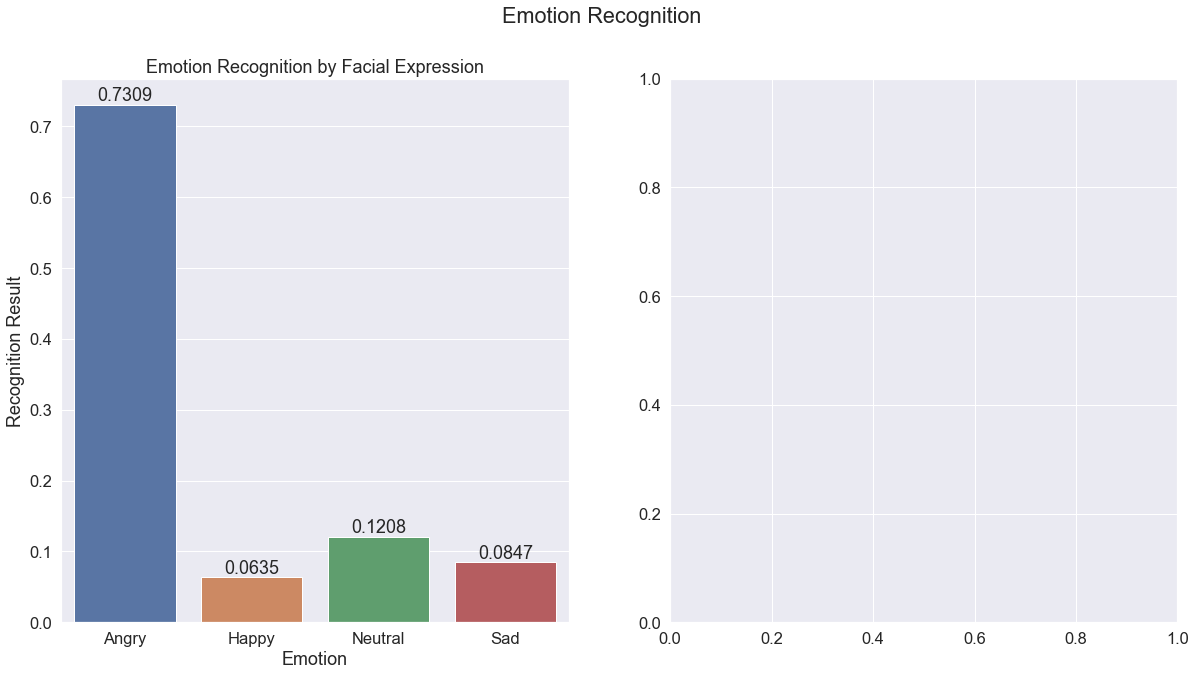

In [9]:
location = 'yx_neutral.mp4'
frames = extractFrames(location)
faces = getCroppedFaceRegions(frames,faceDetector)
shows2(faces)
finalFaceResult = faceRecog(faces,loaded_model_face)
display(finalFaceResult)